In [41]:
# 39개 마커
MARKERS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'LSHO', 'RSHO', 'CLAV', 'RBAK',
           'LUPA', 'RUPA', 'STRN', 'T10', 'LELB', 'RELB', 'LFRM', 'RFRM',
           'LWRA', 'RWRA', 'LWRB', 'RWRB', 'LFIN', 'RFIN', 'LASI', 'RASI',
           'LPSI', 'RPSI', 'LTHI', 'RTHI', 'LKNE', 'RKNE', 'LTIB', 'RTIB',
           'LANK', 'RANK', 'LTOE', 'RTOE', 'LHEE', 'RHEE']
len(MARKERS)

39

In [203]:
import os
import glob

import pandas as pd
import numpy as np
from PIL import Image 
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
DATAPATH = "/Users/sujinlee/Desktop/nims/pd/dataset"
CONTROL = os.path.join(DATAPATH, "Controls")
PD = os.path.join(DATAPATH, "PD")

df_patients = pd.read_csv(os.path.join(DATAPATH, "patients.csv"))
df_null_info = pd.read_csv(os.path.join(DATAPATH, "NULL_info.csv"))

In [21]:
df_patients.head()

,Patient,Category,cntFW,cntBW,pathFW,pathBW
0,AMJ,PD,3,3,"['./dataset/PD/PREP_AMJ_FW1.csv', './dataset/P...","['./dataset/PD/PREP_AMJ_BW1.csv', './dataset/P..."
1,BDY,PD,3,3,"['./dataset/PD/PREP_BDY_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BDY_BW1.csv', './dataset/P..."
2,BGH,PD,3,3,"['./dataset/PD/PREP_BGH_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BGH_BW1.csv', './dataset/P..."
3,BHJ,PD,3,3,"['./dataset/PD/PREP_BHJ_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BHJ_BW1.csv', './dataset/P..."
4,BSB,PD,3,2,"['./dataset/PD/PREP_BSB_FW1.csv', './dataset/P...","['./dataset/PD/PREP_BSB_BW1.csv', './dataset/P..."


In [244]:
len(df_patients)*3

315

In [245]:
df_patients[df_patients["cntFW"] != 3]

,Patient,Category,cntFW,cntBW,pathFW,pathBW
47,KMS,PD,2,3,"['./dataset/PD/PREP_KMS_FW1.csv', './dataset/P...","['./dataset/PD/PREP_KMS_BW1.csv', './dataset/P..."


In [237]:
np.sum(df_patients[df_patients["Category"] == "PD"]["cntFW"].values)

248

In [238]:
np.sum(df_patients[df_patients["Category"] == "Controls"]["cntFW"].values)

66

In [247]:
248+66 - 1

313

In [248]:
np.sum(df_patients[df_patients["Category"] == "PD"]["cntBW"].values)

227

In [249]:
np.sum(df_patients[df_patients["Category"] == "Controls"]["cntBW"].values)

66

In [251]:
227+66 - 1

292

In [252]:
605*0.8

484.0

In [22]:
df_null_info.head()

,Unnamed: 0,path,category,name,trial,marker,NULL frames,frame length,ratio,remove
0,0,./dataset/PD/PREP_AMJ_BW1.csv,PD,AMJ,BW1,LTIB,"[[0.9988, 1.0]]",847,0.0024,False
1,1,./dataset/PD/PREP_AMJ_BW3.csv,PD,AMJ,BW3,LWRB,"[[0.0, 0.0219]]",867,0.0231,False
2,2,./dataset/PD/PREP_AMJ_FW1.csv,PD,AMJ,FW1,LUPA,"[[0.0, 0.0045]]",441,0.0068,False
3,3,./dataset/PD/PREP_AMJ_FW2.csv,PD,AMJ,FW2,LTHI,"[[0.0, 0.0266]]",339,0.0295,False
4,4,./dataset/PD/PREP_AMJ_FW3.csv,PD,AMJ,FW3,LWRA,"[[0.9944, 1.0]]",355,0.0085,False


In [23]:
# 사용하지 않을 데이터 \
# PD/KMS_FW3.csv : 원본 데이터에 ‘RFHD’ 마커가 없음. \
# PD/BGH_FW1.csv : NULL인 컬럼이 너무 많음.

EXCLUDE = [["KMS", "FW3"], ["BGH", "FW1"]]

### 1. frame 수 결정

In [24]:
# null 있는 사람의 trial 별 frame 길이 비교
FRAME = np.max(df_null_info["frame length"])

target = set([ name + "_" + trial for name, trial in zip(df_null_info["name"].values, df_null_info["trial"].values) ])
print("LEN:", len(target))

for t in target:
    name = t.split('_')[0]
    trial = t.split('_')[1]
    print(name, trial)
    
    if not (name == "KMS" and trial == "FW3") and not (name == "BGH" and (trial == "FW1" or trial == "BW1")):
    
        df_t = df_null_info[(df_null_info["name"] == name) & (df_null_info["trial"] == trial)]
        len_t = np.round(df_t["frame length"].values * (1 - df_t["ratio"].values))[0].astype("int64")

        FRAME = min(FRAME, len_t)
        print(FRAME)

LEN: 28
AMJ BW3
847
KES BW2
444
ODS FW2
444
AMJ FW1
438
CHH BW3
438
BGH FW1
BHY FW1
266
BDY FW3
266
BHY BW3
266
SHI BW1
266
NTH BW1
266
KES FW2
266
KimYC BW3
266
NTH BW2
266
ODS FW1
266
JHY BW1
266
JHY FW1
266
AMJ BW1
266
NTH FW1
266
ParkSD FW2
266
JJG FW1
266
ParkSD BW2
266
BGH BW1
ODS BW2
266
AMJ FW2
266
HSH FW2
266
AMJ FW3
266
BHY FW2
266


In [25]:
print("min frame:", FRAME)

min frame: 266


In [26]:
# 전체 데이터 frame 길이 비교
for cate, name, nFW, nBW in zip(df_patients["Category"].values, df_patients["Patient"].values, df_patients["cntFW"].values, df_patients["cntBW"].values):    
    for idx in range(1, nFW+1):
        df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_FW{idx}.csv"))
        print(name, f"FW{idx}")
        print(len(df))
        FRAME = min(FRAME, len(df))
        
    for idx in range(1, nBW+1):
        df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_BW{idx}.csv"))
        print(name, f"BW{idx}")
        print(len(df))
        FRAME = min(FRAME, len(df))

AMJ FW1
441
AMJ FW2
339
AMJ FW3
355
AMJ BW1
847
AMJ BW2
674
AMJ BW3
867
BDY FW1
312
BDY FW2
284
BDY FW3
300
BDY BW1
449
BDY BW2
417
BDY BW3
376
BGH FW1
523
BGH FW2
219
BGH FW3
237
BGH BW1
563
BGH BW2
368
BGH BW3
422
BHJ FW1
674
BHJ FW2
597
BHJ FW3
653
BHJ BW1
1095
BHJ BW2
879
BHJ BW3
1048
BSB FW1
711
BSB FW2
812
BSB FW3
776
BSB BW1
1688
BSB BW2
1957
BSR FW1
235
BSR FW2
216
BSR FW3
226
BSR BW1
345
BSR BW2
321
BSR BW3
278
BTC FW1
379
BTC FW2
400
BTC FW3
366
BTC BW1
470
BTC BW2
1171
BTC BW3
1297
BYH FW1
301
BYH FW2
275
BYH FW3
259
BYH BW1
453
BYH BW2
548
BYH BW3
569
CCC FW1
207
CCC FW2
243
CCC FW3
227
CCC BW1
453
CCC BW2
334
CCC BW3
350
CCD FW1
284
CCD FW2
259
CCD FW3
252
CHK FW1
335
CHK FW2
277
CHK FW3
228
CIB FW1
288
CIB FW2
289
CIB FW3
290
CIB BW1
439
CIB BW2
449
CIB BW3
375
CJH FW1
232
CJH FW2
269
CJH FW3
238
CJH BW1
353
CJH BW2
292
CJH BW3
319
CKC FW1
234
CKC FW2
324
CKC FW3
303
CKC BW1
288
CKC BW2
419
CKC BW3
476
CMJ FW1
286
CMJ FW2
263
CMJ FW3
246
CMJ BW1
633
CMJ BW2
576
CMJ BW3
37

In [27]:
print("min frame:", FRAME)

min frame: 192


### 2. x,y,z 3-channel

In [273]:
DATAPATH

'/Users/sujinlee/Desktop/nims/pd/dataset'

In [274]:
DATAPATH_IMG = DATAPATH + "_img"

In [275]:
os.mkdir(DATAPATH_IMG)

FileExistsError: [Errno 17] File exists: '/Users/sujinlee/Desktop/nims/pd/dataset_img'

In [267]:
# 전체 데이터 x,y,z
for cate, name, nFW, nBW in zip(df_patients["Category"].values, df_patients["Patient"].values, df_patients["cntFW"].values, df_patients["cntBW"].values):    
    for idx in range(1, nFW+1):
        df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_FW{idx}.csv"))
        df_sample = df.copy()
        
        # x, y, z 추출
        df_x = df_sample.filter(regex='X')
        df_y = df_sample.filter(regex='Y')
        df_z = df_sample.filter(regex='Z')

        # MARKERS 컬럼들인지 확인 
        print("LEN X:", len(df_x.columns))
        print("LEN Y:", len(df_y.columns))
        print("LEN Z:", len(df_z.columns))

        assert len(df_x.columns) == 39 and len(set([x.split('_')[0] for x in df_x]) - set(MARKERS)) == 0
        assert len(df_y.columns) == 39 and len(set([x.split('_')[0] for x in df_y]) - set(MARKERS)) == 0
        assert len(df_z.columns) == 39 and len(set([x.split('_')[0] for x in df_z]) - set(MARKERS)) == 0

        # 컬럼 순서 재 확인
        df_x = df_x[[m + "_X" for m in MARKERS]]
        df_y = df_y[[m + "_Y" for m in MARKERS]]
        df_z = df_z[[m + "_Z" for m in MARKERS]]
        
        # 3차원 벡터 생성
        df_img = np.stack([df_x, df_y, df_z], -1)

        # save img
        from PIL import Image
        df_img_jpg = Image.fromarray(df_img.astype(np.uint8))
        df_img_jpg.save(os.path.join(os.path.join(DATAPATH_IMG, cate), f"IMG_{name}_FW{idx}.jpg"))
        
        print(name, f"FW{idx}")
        print(len(df))
        
    for idx in range(1, nBW+1):
        df = pd.read_csv(os.path.join(os.path.join(DATAPATH, cate), f"PREP_{name}_BW{idx}.csv"))
        df_sample = df.copy()
        
        # x, y, z 추출
        df_x = df_sample.filter(regex='X')
        df_y = df_sample.filter(regex='Y')
        df_z = df_sample.filter(regex='Z')

        # MARKERS 컬럼들인지 확인 
        print("LEN X:", len(df_x.columns))
        print("LEN Y:", len(df_y.columns))
        print("LEN Z:", len(df_z.columns))

        assert len(df_x.columns) == 39 and len(set([x.split('_')[0] for x in df_x]) - set(MARKERS)) == 0
        assert len(df_y.columns) == 39 and len(set([x.split('_')[0] for x in df_y]) - set(MARKERS)) == 0
        assert len(df_z.columns) == 39 and len(set([x.split('_')[0] for x in df_z]) - set(MARKERS)) == 0

        # 컬럼 순서 재 확인
        df_x = df_x[[m + "_X" for m in MARKERS]]
        df_y = df_y[[m + "_Y" for m in MARKERS]]
        df_z = df_z[[m + "_Z" for m in MARKERS]]
        
        # 3차원 벡터 생성
        df_img = np.stack([df_x, df_y, df_z], -1)

        # save img
        from PIL import Image
        df_img_jpg = Image.fromarray(df_img.astype(np.uint8))
        df_img_jpg.save(os.path.join(os.path.join(DATAPATH_IMG, cate), f"IMG_{name}_BW{idx}.jpg"))

        print(name, f"BW{idx}")

LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ FW1
441
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ FW2
339
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ FW3
355
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ BW1
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
AMJ BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY FW1
312
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY FW2
284
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY FW3
300
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY BW1
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
BDY BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH FW1
523
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH FW2
219
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH FW3
237
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH BW1
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
BGH BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ FW1
674
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ FW2
597
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ FW3
653
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ BW1
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ BW2
LEN X: 39
LEN Y: 39
LEN Z: 39
BHJ BW3
LEN X: 39
LEN Y: 39
LEN Z: 39
BSB FW1
71

In [219]:
name_sample = df_patients["Patient"].values[1]
df_sample = pd.read_csv(os.path.join(PD, f"PREP_{name_sample}_BW1.csv"))

In [220]:
df_sample.head()

,Frame,LFHD_X,LFHD_Y,LFHD_Z,RFHD_X,RFHD_Y,RFHD_Z,LBHD_X,LBHD_Y,LBHD_Z,...,LTOE_Z,RTOE_X,RTOE_Y,RTOE_Z,LHEE_X,LHEE_Y,LHEE_Z,RHEE_X,RHEE_Y,RHEE_Z
0,469,-94.588425,1265.890381,1472.445679,24.794617,1245.785645,1476.407349,-119.151863,1096.367920,1460.398804,...,31.684938,93.713570,1241.651001,60.347408,-57.385754,935.999695,35.451641,24.084532,1064.466675,89.558754
1,470,-94.585846,1265.635864,1472.480713,24.823648,1245.557129,1476.452515,-119.132408,1096.109741,1460.427734,...,31.687412,93.654007,1240.828979,60.382042,-57.386410,936.001892,35.445808,24.096382,1063.663208,89.839653
2,471,-94.576195,1264.502441,1472.637573,24.949701,1244.524414,1476.653442,-119.067604,1094.957886,1460.567627,...,31.700693,93.388199,1237.134033,60.548206,-57.430729,935.979858,35.428200,24.168474,1060.049683,91.078918
3,472,-94.560875,1261.966675,1472.995483,25.219524,1242.183716,1477.091309,-118.955185,1092.391602,1460.900024,...,31.734743,92.811363,1228.829590,60.953049,-57.592819,935.878967,35.387516,24.356722,1051.982178,93.854851
4,473,-94.543846,1257.867920,1473.583130,25.615763,1238.348267,1477.763916,-118.794563,1088.266724,1461.454102,...,31.805477,91.924492,1215.397583,61.669880,-57.883057,935.683716,35.290768,24.719568,1039.079834,98.360619


In [221]:
# x, y, z 추출
df_x = df.filter(regex='X')
df_y = df.filter(regex='Y')
df_z = df.filter(regex='Z')

In [222]:
# MARKERS 컬럼들인지 확인 
print("LEN X:", len(df_x.columns))
print("LEN Y:", len(df_y.columns))
print("LEN Z:", len(df_z.columns))

assert len(df_x.columns) == 39 and len(set([x.split('_')[0] for x in df_x]) - set(MARKERS)) == 0
assert len(df_y.columns) == 39 and len(set([x.split('_')[0] for x in df_y]) - set(MARKERS)) == 0
assert len(df_z.columns) == 39 and len(set([x.split('_')[0] for x in df_z]) - set(MARKERS)) == 0

LEN X: 39
LEN Y: 39
LEN Z: 39


In [223]:
# 컬럼 순서 재 확인
df_x = df_x[[m + "_X" for m in MARKERS]]
df_y = df_y[[m + "_Y" for m in MARKERS]]
df_z = df_z[[m + "_Z" for m in MARKERS]]

In [224]:
# 3차원 벡터 생성
df_img = np.stack([df_x, df_y, df_z], -1)

In [225]:
df_img.shape

(350, 39, 3)

In [226]:
# save img
from PIL import Image
df_img_jpg = Image.fromarray(df_img.astype(np.uint8))
df_img_jpg.save(os.path.join(DATAPATH, "your_file.jpg"))

In [195]:
# save numpy
np.save(os.path.join(DATAPATH, "sample.npy"), df_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


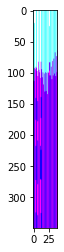

In [232]:
import matplotlib.pyplot as plt

plt.imshow(df_img)

### 3. resize 비교

#### 1) numpy.resize

In [139]:
img_np = df_x.values.copy()
print("Initial Size:", img_np.shape)
img_np.resize(200, 39)
print("After Resize:", img_np.shape)

Initial Size: (350, 39)
After Resize: (200, 39)


In [140]:
# 확인용

# 시작값
print("Idx   0 :", (img_np[0] == df_x.values[0]).all())

# 중간값
idx = int(len(img_np)/2)
print("Idx", idx, ": ", end='')
print((img_np[idx] == df_x.values[idx]).all())

# 끝값
print("Idx  -1 :", (img_np[-1] == df_x.values[len(img_np)-1]).all())

# 길이를 자른 것인지 확인
print("Is Crop ?", (img_np == df_x.values[:len(img_np)]).all())

Idx   0 : True
Idx 100 : True
Idx  -1 : True
Is Crop ? True


#### 2) tf.image.resize

<mark>bilinear</mark>: Bilinear interpolation. If antialias is true, becomes a hat/tent filter function with radius 1 when downsampling.\
<mark>lanczos3</mark>: Lanczos kernel with radius 3. High-quality practical filter but may have some ringing, especially on synthetic images.\
<mark>lanczos5</mark>: Lanczos kernel with radius 5. Very-high-quality filter but may have stronger ringing.\
<mark>bicubic</mark>: Cubic interpolant of Keys. Equivalent to Catmull-Rom kernel. Reasonably good quality and faster than Lanczos3Kernel, particularly when upsampling.\
<mark>gaussian</mark>: Gaussian kernel with radius 3, sigma = 1.5 / 3.0.\
<mark>nearest</mark>: Nearest neighbor interpolation. antialias has no effect when used with nearest neighbor interpolation.\
<mark>area</mark>: Anti-aliased resampling with area interpolation. antialias has no effect when used with area interpolation; it always anti-aliases.\
<mark>mitchellcubic</mark>: Mitchell-Netravali Cubic non-interpolating filter. For synthetic images (especially those lacking proper prefiltering), less ringing than Keys cubic kernel but less sharp.

##### - No option

In [188]:
img_tf = tf.constant(df_img)
img_tf = img_tf[tf.newaxis, ...]

In [189]:
print("Initial Size:", img_tf.shape.as_list())

img_tf_0_resized = tf.image.resize(img_tf[0], [200,39])
print("After Resize:", img_tf_0_resized.shape.as_list())

Initial Size: [1, 350, 39, 3]
After Resize: [200, 39, 3]


In [190]:
# 채널 분리
img_tf_0_x = img_tf_0_resized[:,:,0]
img_tf_0_y = img_tf_0_resized[:,:,1]
img_tf_0_z = img_tf_0_resized[:,:,2]

In [191]:
# 확인용

# 시작값
print("Idx   0 :", (img_tf_0_x[0].numpy() == df_x.values[0]).all())

# 중간값
idx = int(len(img_np)/2)
print("Idx", idx, ": ", end='')
print((img_tf_0_x[idx].numpy() == df_x.values[idx]).all())

# 끝값
print("Idx  -1 :", (img_tf_0_x[-1].numpy() == df_x.values[len(img_np)-1]).all())

# 길이를 자른 것인지 확인
print("Is Crop ?", (img_tf_0_x.numpy() == df_x.values[:len(img_np)]).all())

Idx   0 : False
Idx 100 : False
Idx  -1 : False
Is Crop ? False


##### - method: bilinear


In [192]:
print("Initial Size:", img_tf.shape.as_list())

img_tf_0_resized_bilinear = tf.image.resize(img_tf[0], [200,39], method="bilinear")
print("After Resize:", img_tf_0_resized_bilinear.shape.as_list())

Initial Size: [1, 350, 39, 3]
After Resize: [200, 39, 3]


In [193]:
# 채널 분리
img_tf_0_x_bilinear = img_tf_0_resized_bilinear[:,:,0]
img_tf_0_y_bilinear = img_tf_0_resized_bilinear[:,:,1]
img_tf_0_z_bilinear = img_tf_0_resized_bilinear[:,:,2]

In [194]:
# 확인용

# 시작값
print("Idx   0 :", (img_tf_0_x_bilinear[0].numpy() == df_x.values[0]).all())

# 중간값
idx = int(len(img_np)/2)
print("Idx", idx, ": ", end='')
print((img_tf_0_x_bilinear[idx].numpy() == df_x.values[idx]).all())

# 끝값
print("Idx  -1 :", (img_tf_0_x_bilinear[-1].numpy() == df_x.values[len(img_np)-1]).all())

# 길이를 자른 것인지 확인
print("Is Crop ?", (img_tf_0_x_bilinear.numpy() == df_x.values[:len(img_np)]).all())

Idx   0 : False
Idx 100 : False
Idx  -1 : False
Is Crop ? False


#### 3) tf.ImageDataGenerator(~, resize=)

#### 4) tf.keras.preprocessing.image.smart_resize
- interpolation\
String, interpolation to use for resizing. Defaults to 'bilinear'. Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.

In [200]:
print("Initial Size:", img_tf.shape.as_list())

img_keras_resized_bilinear = tf.keras.preprocessing.image.smart_resize(img_tf, (200, 39), interpolation="bilinear")
print("After resize:", img_keras_resized_bilinear.shape.as_list())

Initial Size: [1, 350, 39, 3]
After resize: [1, 200, 39, 3]


### 4. data load

In [ ]:
# 샘플
train_datagen = ImageDataGenerator(
    #Your code here. Should at least have a rescale. Other parameters can help with overfitting.)
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255) #Your Code here

train_generator = train_datagen.flow_from_directory(
    #Your Code Here
    directory= DATAPATH,
    target_size=(300, 300),
    batch_size=128,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    #Your Code Here
    directory='tmp/testdata/',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary')

- frame: 192/200 x 39

CONV1
- n_filter: 16
- filter: 3x3
- stride: 2x1
- padding: 1x1
100x39\

- pooling: 2x2
- stride: 2x1
50x38\

CONV2
- n_filter: 32
- filter: 3x3
- stride: 2x2
- padding: 1x1
25x18

- pooing: 2x2
- stride: 2x2
13x9x32

FLATTEN\

Dense1
- n_node: 512

Dense2
- n_node: 64

Dense1
- n_node: 1

In [253]:
13*9*32

3744

In [280]:
datagen = ImageDataGenerator(
    #Your code here. Should at least have a rescale. Other parameters can help with overfitting.)
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
    fill_mode='nearest')

train_generator = datagen.flow_from_directory(
    #Your Code Here
    directory= DATAPATH + "_img",
    target_size=(200, 39),
    batch_size=1,  # 1, 8
    class_mode='binary')

Found 608 images belonging to 2 classes.


### 5. model

def solution_model():
    mnist = tf.keras.datasets.mnist
    
    # YOUR CODE HERE
    (x_train, y_train),(x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test = x_test / 255.0   

    model = tf.keras.models.Sequential([
        tfl.Flatten(input_shape=(28, 28)),
        tfl.Dense(128, activation='relu'),
        tfl.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train, y_train, epochs=10, verbose=1, callbacks=[callbacks])
    print( 'Final accuracy: ' + str(history.history['accuracy'][-1]) )

    # model.evaluate(x_test, y_test)
    # classifications = model.predict(x_test)
    # print(classifications[1])  # softmax의 output
    # print(y_test[1])           # 실제 정답 라벨

    return model

model = solution_model()

CONV1
- n_filter: 16
- filter: 3x3
- stride: 2x1
- padding: 1x1
100x39\

- pooling: 2x2
- stride: 2x1
50x38\

CONV2
- n_filter: 32
- filter: 3x3
- stride: 2x2
- padding: 1x1
25x18

- pooing: 2x2
- stride: 2x2
13x9x32

FLATTEN\

Dense1
- n_node: 512

Dense2
- n_node: 64

Dense1
- n_node: 1

In [270]:
import tensorflow.keras.layers as tfl
from tensorflow.keras.optimizers import Adam

In [281]:
# Note the input shape specified on your first layer must be (300,300,3)
# You should not change the last layer

model = tf.keras.models.Sequential([tfl.Conv2D(16, (3,3), (2,1), activation='relu', input_shape=(200,39,3)),
                                    tfl.MaxPooling2D((2,2),(2,1)), 
                                    tfl.Conv2D(32, (3,3), (2,2), activation='relu'),
                                    tfl.MaxPooling2D((2,2),(2,2)), 
                                    tfl.Flatten(),
                                    tfl.Dense(512, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(64, activation='relu'),
                                    tfl.Dropout(0.5),
                                    tfl.Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [282]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 99, 37, 16)        448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 36, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 17, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 8, 32)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

In [283]:
history = model.fit_generator(train_generator, 
                              epochs=20,
                            #   callbacks=[callbacks],
                              verbose=2
#                               validation_data=validation_generator
                             )

Epoch 1/20
608/608 - 3s - loss: 0.6025 - accuracy: 0.7763
Epoch 2/20
608/608 - 3s - loss: 0.5296 - accuracy: 0.7829
Epoch 3/20
608/608 - 3s - loss: 0.5276 - accuracy: 0.7829
Epoch 4/20
608/608 - 3s - loss: 0.4782 - accuracy: 0.7829
Epoch 5/20
608/608 - 3s - loss: 0.4267 - accuracy: 0.7862
Epoch 6/20
608/608 - 3s - loss: 0.3823 - accuracy: 0.8125
Epoch 7/20
608/608 - 3s - loss: 0.3308 - accuracy: 0.8536
Epoch 8/20
608/608 - 3s - loss: 0.2483 - accuracy: 0.8947
Epoch 9/20
608/608 - 3s - loss: 0.2021 - accuracy: 0.8997
Epoch 10/20
608/608 - 3s - loss: 0.1586 - accuracy: 0.9424
Epoch 11/20
608/608 - 3s - loss: 0.1549 - accuracy: 0.9655
Epoch 12/20
608/608 - 3s - loss: 0.0916 - accuracy: 0.9655
Epoch 13/20
608/608 - 3s - loss: 0.0792 - accuracy: 0.9819
Epoch 14/20
608/608 - 3s - loss: 0.1104 - accuracy: 0.9539
Epoch 15/20
608/608 - 3s - loss: 0.0716 - accuracy: 0.9803
Epoch 16/20
608/608 - 3s - loss: 0.0899 - accuracy: 0.9671
Epoch 17/20
608/608 - 3s - loss: 0.0847 - accuracy: 0.9753
Epoch 

In [ ]:
num = 3
path = f"/content/drive/MyDrive/TF_certificate/TEST/Problem{num}.h5"
model.save(path)